# Pyesgf all in one place!
---
This is a guide to the way I've been doing my CMIP6 multimodal analysis generalized so that hopefully people can get some use out of it!

I've included all library and functions used in a single box to hopefully enable a plug and play sort of analysis - however the approaches used here may not be suitable to every type of analysis.

### Analysis Structure
- Identify models, variables and scenarios (amip, SSP245, abrupt4x-CO2, ect)
- Use ESGF to find and compile an extensive list of file names/ paths
- Download the 'raw' data from ESGF locally (Can be memory intensive)
- 'Preprocess' data and store these processed data products locally to minimize storage use
- Read in and manipulate these secondary data products to preform analysis

The more linear method of doing this can be found detailed in the PYESGF_Guide however due to this being a fairly slow approach, the liberal use of paralelle processing and logic to avoid repeating tasks has been employed making this whole thing much faster but also fairly confusing to work with

Please reach out with any questions that might come up when using this or with features you'd like to see added to make this more friendly to use. Also thank you to Anna Mackie for crash testing this with me, most of the improvements in this are from there.

---

## Functions:
1. Meta Data / Model lists
3. Parellel processor
4. File Search infrastructure
5. Download infrastructure

All the functions and librarys and just in this collapsed cell so be sure to run before doing anything!

In [55]:
import os
import xarray as xr  
import cftime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor
import concurrent.futures
import threading

from dask.diagnostics import ProgressBar
import requests
from tqdm import tqdm

from pyesgf.search import SearchConnection
###################################################################################################################################
##                                           Meta Data Helper Functions
###################################################################################################################################
def getModels(MIP = 'CMIP', offline = True):
    if MIP == 'CMIP' and offline:
        return np.array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR',
       'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CanESM5', 'CanESM5-1',
       'CanESM5-CanOE', 'CAS-ESM2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM',
       'CESM2-WACCM-FV2', 'CIESM', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5',
       'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1',
       'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA', 'E3SM-2-0', 'EC-Earth3',
       'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-LR',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'EC-Earth3P-VHR',
       'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-AM4', 'GFDL-CM4',
       'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H',
       'GISS-E2-2-G', 'GISS-E2-2-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM',
       'ICON-ESM-LR', 'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM5A2-INCA', 'IPSL-CM6A-ATM-LR-REPROBUS', 'IPSL-CM6A-LR',
       'IPSL-CM6A-LR-INCA', 'KACE-1-0-G', 'KIOST-ESM', 'MCM-UA-1-0',
       'MIROC-ES2H', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1',
       'NorESM1-F', 'NorESM2-LM', 'SAM0-UNICON', 'TaiESM1', 'UKESM1-0-LL',
       'UKESM1-1-LL'])
    CMI6P_df = pd.read_csv('CMIP6 Source IDs.csv')
    MIP = 'CMIP'
    CMI6P_df = CMI6P_df[CMI6P_df['MIP Involvement (Actual)'].str.contains(fr'(^|,\s*){MIP}(\s*,|$)', na=False, regex=True)].reset_index(drop= True)
    models = CMI6P_df.Source_ID
    return models.values
    
def extract_varientID(string):  # also Known as extract_8_chars
    start_index = string.find('_r') 
    end_index = string.find('_', start_index+1)
    return string[start_index+1:end_index]

def extract_monType(string):  # also Known as extract_8_chars
    start_index = string.find('_') 
    end_index = string.find('_', start_index+1)
    return string[start_index+1:end_index]

def extract_SimNums(string):
    try:
        start_index = string.find('_r')
        end_index = string.find('i', start_index)
        r = int(string[start_index + 2:end_index])

        start_index = string.find('i', end_index)
        end_index = string.find('p', start_index)
        i = int(string[start_index + 1:end_index])

        start_index = string.find('p', end_index)
        end_index = string.find('f', start_index)
        p = int(string[start_index + 1:end_index])

        start_index = string.find('f', end_index)
        end_index = string.find('_', start_index)
        f = int(string[start_index + 1:end_index])
        
        return r, i, p, f
    except Exception as e:
        # Provide feedback for debugging
        print(f"Error processing string '{string}': {e}")
        return None, None, None, None
   
def getPeriod(filename):
    experiments = ['1pctCO2', '1pctCO2-4xext', '1pctCO2-bgc', '1pctCO2-cdr', '1pctCO2-rad', '1pctCO2Ndep', '1pctCO2Ndep-bgc', '1pctCO2to4x-withism', 'G1', 'G6solar', 'G6sulfur', 'G7cirrus', 'a4SST', 'a4SSTice', 'a4SSTice-4xCO2', 'abrupt-0p5xCO2', 'abrupt-2xCO2', 'abrupt-4xCO2', 'abrupt-solm4p', 'abrupt-solp4p', 'amip', 'amip-4xCO2', 'amip-TIP', 'amip-TIP-nosh', 'amip-a4SST-4xCO2', 'amip-future4K', 'amip-hist', 'amip-hld', 'amip-lfmip-pObs', 'amip-lfmip-pdLC', 'amip-lfmip-rmLC', 'amip-lwoff', 'amip-m4K', 'amip-p4K', 'amip-p4K-lwoff', 'amip-piForcing', 'aqua-4xCO2', 'aqua-control', 'aqua-control-lwoff', 'aqua-p4K', 'aqua-p4K-lwoff', 'control-1950', 'dcppA-assim', 'dcppA-hindcast', 'dcppB-forecast', 'dcppC-amv-ExTrop-neg', 'dcppC-amv-ExTrop-pos', 'dcppC-amv-Trop-neg', 'dcppC-amv-Trop-pos', 'dcppC-amv-neg', 'dcppC-amv-pos', 'dcppC-atl-control', 'dcppC-atl-pacemaker', 'dcppC-atl-spg', 'dcppC-forecast-addAgung', 'dcppC-forecast-addElChichon', 'dcppC-forecast-addPinatubo', 'dcppC-hindcast-noAgung', 'dcppC-hindcast-noElChichon', 'dcppC-hindcast-noPinatubo', 'dcppC-ipv-NexTrop-neg', 'dcppC-ipv-NexTrop-pos', 'dcppC-ipv-neg', 'dcppC-ipv-pos', 'dcppC-pac-control', 'dcppC-pac-pacemaker', 'deforest-globe', 'esm-1pct-brch-1000PgC', 'esm-1pct-brch-2000PgC', 'esm-1pct-brch-750PgC', 'esm-1pctCO2', 'esm-hist', 'esm-pi-CO2pulse', 'esm-pi-cdr-pulse', 'esm-piControl', 'esm-piControl-spinup', 'esm-sp585', 'esm-sp585-bgc', 'esm-ssp534-over', 'esm-ssp585', 'esm-ssp585-ocn-alk', 'esm-ssp585-ocn-alk-stop', 'esm-ssp585-ssp126Lu', 'esm-ssp585ext', 'faf-all', 'faf-antwater-stress', 'faf-heat', 'faf-heat-NA0pct', 'faf-heat-NA50pct', 'faf-passiveheat', 'faf-stress', 'faf-water', 'futSST-pdSIC', 'highres-future', 'highresSST-future', 'highresSST-present', 'hist-1950', 'hist-1950HC', 'hist-CO2', 'hist-GHG', 'hist-GHG-cmip5', 'hist-aer', 'hist-aer-cmip5', 'hist-bgc', 'hist-nat', 'hist-nat-cmip5', 'hist-noLu', 'hist-piAer', 'hist-piNTCF', 'hist-resAMO', 'hist-resIPO', 'hist-sol', 'hist-spAer-all', 'hist-stratO3', 'hist-totalO3', 'hist-volc', 'histSST', 'histSST-1950HC', 'histSST-noLu', 'histSST-piAer', 'histSST-piCH4', 'histSST-piN2O', 'histSST-piNTCF', 'histSST-piO3', 'historical', 'historical-cmip5', 'historical-ext', 'historical-withism', 'land-cCO2', 'land-cClim', 'land-crop-grass', 'land-crop-noFert', 'land-crop-noIrrig', 'land-crop-noIrrigFert', 'land-hist', 'land-hist-altLu1', 'land-hist-altLu2', 'land-hist-altStartYear', 'land-hist-cruNcep', 'land-hist-princeton', 'land-hist-wfdei', 'land-noFire', 'land-noLu', 'land-noShiftCultivate', 'land-noWoodHarv', 'lgm', 'lig127k', 'midHolocene', 'midPliocene-eoi400', 'modelSST-futArcSIC', 'modelSST-pdSIC', 'omip1', 'omip1-spunup', 'omip2', 'omip2-spunup', 'pa-futAntSIC', 'pa-futArcSIC', 'pa-futArcSIC-ext', 'pa-pdSIC', 'pa-pdSIC-ext', 'pa-piAntSIC', 'pa-piArcSIC', 'past1000', 'past2k', 'pdSST-futAntSIC', 'pdSST-futArcSIC', 'pdSST-futArcSICSIT', 'pdSST-futBKSeasSIC', 'pdSST-futOkhotskSIC', 'pdSST-pdSIC', 'pdSST-pdSICSIT', 'pdSST-piAntSIC', 'pdSST-piArcSIC', 'piClim-2xDMS', 'piClim-2xNOx', 'piClim-2xVOC', 'piClim-2xdust', 'piClim-2xfire', 'piClim-2xss', 'piClim-4xCO2', 'piClim-BC', 'piClim-CH4', 'piClim-HC', 'piClim-N2O', 'piClim-NH3', 'piClim-NOx', 'piClim-NTCF', 'piClim-O3', 'piClim-OC', 'piClim-SO2', 'piClim-VOC', 'piClim-aer', 'piClim-anthro', 'piClim-control', 'piClim-ghg', 'piClim-histaer', 'piClim-histall', 'piClim-histghg', 'piClim-histnat', 'piClim-lu', 'piClim-spAer-aer', 'piClim-spAer-anthro', 'piClim-spAer-histaer', 'piClim-spAer-histall', 'piControl', 'piControl-cmip5', 'piControl-spinup', 'piControl-withism', 'piSST', 'piSST-4xCO2', 'piSST-4xCO2-rad', 'piSST-pdSIC', 'piSST-piSIC', 'piSST-pxK', 'rad-irf', 'rcp26-cmip5', 'rcp45-cmip5', 'rcp85-cmip5', 'spinup-1950', 'ssp119', 'ssp126', 'ssp126-ssp370Lu', 'ssp245', 'ssp245-GHG', 'ssp245-aer', 'ssp245-cov-GHG', 'ssp245-cov-aer', 'ssp245-cov-fossil', 'ssp245-cov-modgreen', 'ssp245-cov-strgreen', 'ssp245-covid', 'ssp245-nat', 'ssp245-stratO3', 'ssp370', 'ssp370-lowNTCF', 'ssp370-lowNTCFCH4', 'ssp370-ssp126Lu', 'ssp370SST', 'ssp370SST-lowAer', 'ssp370SST-lowBC', 'ssp370SST-lowCH4', 'ssp370SST-lowNTCF', 'ssp370SST-lowNTCFCH4', 'ssp370SST-lowO3', 'ssp370SST-ssp126Lu', 'ssp370pdSST', 'ssp434', 'ssp460', 'ssp534-over', 'ssp534-over-bgc', 'ssp585', 'ssp585-bgc', 'ssp585-withism', 'volc-long-eq', 'volc-pinatubo-full', 'volc-pinatubo-strat', 'volc-pinatubo-surf']
    for experiment in experiments:
        if experiment in filename:
            return experiment
    return None  # Or return 'unknown'
    
def whichVar(filename):
    start_index = filename.find('_')
    return filename[:start_index]

def whichTimestep(filename):
    frequencies = ['1hr', '1hrCM', '1hrPt', '3hr', '3hrPt', '6hr', '6hrPt', 'day', 'dec', 'fx', 'mon', 'monC', 'monPt', 'month', 'subhrPt', 'yr', 'yrPt']
    for freq in frequencies:
        if freq in filename:
            return freq
    return np.nan  # Or return 'np.nan'
   

def whichGrid(filename):
    varID = extract_varientID(filename)
    start_index = filename.find(varID) +len(varID)
    end_index = filename.find('_', start_index+1)
    return filename[start_index+1:end_index]

def extractDates(string):
    ncFind = string.find('.nc') 
    ncBack = string.rfind('-', 0, ncFind)
    dback = (ncFind-ncBack)-1
    stop = string[ncBack+1:ncFind]
    start = string[ncBack-dback:ncBack]
    try:
        return extractYear(start), extractYear(stop)
    except:
        print(string)
def extractYear(Date):
    return int(Date[:4])


###################################################################################################################################
##                                           Parallel Processor
###################################################################################################################################
def parallel_execution(func, inputs, processes=None):
    """my generic parallel processing function"""
    from multiprocessing import Pool, cpu_count

    # Set the number of processes to use (default: number of CPU cores)
    if processes is None:
        processes = cpu_count()

    # Create a pool of worker processes
    with Pool(processes=processes) as pool:
        # Map the function to inputs and distribute across processors
        results = pool.map(func, inputs)

    return results

###################################################################################################################################
##                                           File Search Infrastructure
###################################################################################################################################
def fileContextSearch(inputs):
    '''Helper function for seachFPs: puts together a dictionary with search results'''
    res, model = inputs
    hit = res.file_context().search()
    files = [
        {
            'model': model,
            'filename': f.filename, 
            'download_url': f.download_url, 
            'opendap_url': f.opendap_url
        } 
        for f in hit
        ]
    return files

def searchFPs(conn, model, variables, tStep='day', period='SSP245'):
    '''given model and variables looks for CMIP6 models filling criteria
    returns as flattened df - consider saving along the way'''
    query = conn.new_context(
            project="CMIP6",     
            experiment_id=period,
            source_id=model,
            frequency=tStep,
            variable_id=variables
        )
    ## Looking for Data
    results = query.search()
    inputs = list(zip(results, np.repeat(model, len(results))))
    
    files = parallel_execution(fileContextSearch, inputs)
    
    flat_files = [file for sublist in files for file in sublist]

    return pd.DataFrame(flat_files)

def addMetaData(df):
    '''Adds some additional columns for df'''
    df['Varient'] = df.filename.apply(extract_varientID)
    df['period'] = df.filename.apply(getPeriod)
    df['Var'] = df.filename.apply(whichVar)
    df['grid'] = df.filename.apply(whichGrid)
    df['timeStep'] = df.filename.apply(whichTimestep)
    df[['start', 'stop']] = df['filename'].apply(extractDates).apply(pd.Series)
    df[['r', 'i', 'p', 'f']] = pd.DataFrame(
                df['filename'].apply(extract_SimNums).tolist(),
                index=df.index)
    return df
    
def handleFPdf(df, model, location='FPs/', doPrint=True):
    if not os.path.exists(location): 
        os.mkdir(location)
        print(f'Created location {location}')
    if len(df) != 0:
        df = addMetaData(df)
        if not os.path.exists(os.path.join(location, f'FPs_{model}.csv')):
            df.to_csv(os.path.join(location, f'FPs_{model}.csv'), index = None)
        else: 
            df_old = pd.read_csv(os.path.join(location, f'FPs_{model}.csv'), index_col = None)
            df = pd.concat([df_old, df], ignore_index=True)
            df = df.drop_duplicates(subset=['download_url'], keep='last')
            df.to_csv(os.path.join(location, f'FPs_{model}.csv'), index=None)
            
        missingVars = list(set(variables)-set(df.Var.unique()))
        if len(missingVars)!=0:
            if doPrint: print(f'Model: {model} had no result {missingVars}  :(')
    else:
        if doPrint: print(f'Model: {model} had no results')
    return None

def pickVarientandFilter(df):
    '''This function takes a df with filenames and meta data (specifically varient ids) and finds shared varients for each model and period
    Minimizing varient number to keep toward r1f1p1i1 although deviations in the f and p components are likely'''
    shared_combinations = {}
    
    for (period, model), group in df.groupby(['period', 'model']):
        combinations_per_variable = (
            group.groupby('Var')[['r', 'f', 'p', 'i']]
            .apply(lambda var_group: set(tuple(x) for x in var_group.to_numpy()))
            .tolist()
        )
        if combinations_per_variable:
            shared_combinations_for_group = set.intersection(*combinations_per_variable)
        else:
            shared_combinations_for_group = set()
        shared_combinations[(period, model)] = shared_combinations_for_group
    
    filtered_dfs = []
        
    for (period, model), combinations in shared_combinations.items():
        if combinations:  
            first_combination = sorted(list(combinations))[0]
            
            filtered_df = df[
                (df['period'] == period) & 
                (df['model'] == model) & 
                (df[['r', 'f', 'p', 'i']].apply(tuple, axis=1) == first_combination)
            ]
            filtered_dfs.append(filtered_df)
    
    filtered_dfs = pd.concat(filtered_dfs, ignore_index=True)

    return filtered_dfs

###################################################################################################################################
##                                           Download Infrastructure
###################################################################################################################################
def download_concurrently(args):
    """This one is a mystery, takes args which are a tuple of paths (different download paths) for file i
    it starts a new thread for each seperate path with a shared signal (Stop event) It tries to download each file simultaniously but bc each file tries to download with the same name there are temporary file names that are given. The download and check function does the actual downloading  and checking to see if the file is larger than 1kb

    When it succesfully downloads a file larger than a kb it sends the stopevent signal to end all threads it created
    it then clears all but the sucessfully downloaded file and then renames the good file to what it was meant to be named in the first place 
    """

    paths, i,TempDataLocation  = args[0], args[1], args[2]
    stop_event = threading.Event()  # Each call has its own stop signal

    downloadPaths = paths[paths.filename == i].reset_index(drop=True)
    final_filename = os.path.join(TempDataLocation, i)

    # Create temporary filenames
    temp_filenames = [os.path.join(TempDataLocation, f'{i}_temp_{idx}') for idx in range(len(downloadPaths))]
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(download_and_check, row['download_url'], temp_filename, final_filename, stop_event): (row['download_url'], temp_filename)
            for (_, row), temp_filename in zip(downloadPaths.iterrows(), temp_filenames)
        }

        try:
            for future in concurrent.futures.as_completed(futures):
                url, temp_filename = futures[future]
                try:
                    success, valid_temp_filename = future.result()
                    
                    if success:
                        
                        stop_event.set()  # Signal all threads in this batch to stop
                        
                        # Cancel remaining futures (prevents unstarted tasks)
                        for f in futures:
                            if not f.done():
                                f.cancel()
                        
                        executor.shutdown(wait=False, cancel_futures=True)  # Forcefully stop executor
                        
                        # Remove other temp files
                        for other_temp_filename in temp_filenames:
                            if other_temp_filename != valid_temp_filename and os.path.exists(other_temp_filename):
                                os.remove(other_temp_filename)

                        # Rename the successful download to final filename
                        os.rename(valid_temp_filename, final_filename)
                        return
                
                except concurrent.futures.TimeoutError:
                    print(f"Download timed out: {url}")
        
        except KeyboardInterrupt:
            print("\nInterrupted! Stopping downloads...")
            stop_event.set()  # Signal threads in this batch to stop
            executor.shutdown(wait=False, cancel_futures=True)  # Force shutdown
            raise  # Re-raise to terminate execution
        except Exception as e:
            print(e, ' Somewhere in  download_concurrently')
            
def download_and_check(url, temp_filename, final_filename, stop_event):
    """Download file but stop if the event is set."""
    try:
        r = requests.get(url, stream=True, timeout=10)
        r.raise_for_status()
        
        with open(temp_filename, "wb") as f:
            for chunk in r.iter_content(1024):
                if stop_event.is_set():  # Actively check stop condition
                    return False, None
                f.write(chunk)

        return True, temp_filename  # Return success flag and valid temp file
    
    except Exception as e:
        return False, None
        
def preprocess_and_download(models, df, variables, preprocessFunc, overRide = False, TempDataLocation = 'TempData/', maxWorkers=2):
    ''' This is where we get a little more theoretical - Lets assume that we want to download the raw data for each of given variables and periods
    periods - more of a relic of my own work but could be like historical or pmip'''
    if not os.path.exists(TempDataLocation): 
        os.mkdir(TempDataLocation)
        
    tasks = [
        (period, Var, df, model, TempDataLocation, preprocessFunc)
        for period in df.period.unique()
        for Var in variables
        for model in models
        if  (not os.path.exists(os.path.join(TempDataLocation, f'{model}_{period}_rlut_processed.nc'))) or  overRide
    ]
    ## The key thing here is the process_period_var function - this will do the heavy lift for downloading and preprocessing (if we need preprocessing)
    with ThreadPoolExecutor(max_workers=maxWorkers) as executor: ### Ramp up max worker if needed
        executor.map(lambda args: process_period_var(*args), tasks)
    for filename in os.listdir(TempDataLocation):
        file_path = os.path.join(TempDataLocation, filename)

        if ("_temp" in filename) & (os.path.getsize(file_path) < 1024):
            os.remove(file_path)


def process_period_var(period, Var, df, model, TempDataLocation, preprocessFunc):
    """Handles downloading data for a single (period, variable) combination using download concurrently - inputs are split up by file path unique
    """
    paths = df[((df.model == model) & (df.period == period))&(df.Var == Var)].reset_index(drop=True)
    saveName = os.path.join(TempDataLocation, f'{model}_{period}_{Var}_processed.nc')

    if not os.path.exists(saveName):  # Check if processed dataset has already been created
        try:
            # Prepare inputs for parallel processing of file downloads
            inputs = [(paths, i, TempDataLocation) for i in paths.filename.unique()]
            print(f'Downloading data for {saveName}')
            parallel_execution(download_concurrently, inputs, processes = 8)  # Keep using multiprocessing for downloads
            
            # Open Raw Data
            ds = xr.open_mfdataset(sorted([os.path.join(TempDataLocation, fn) for fn in paths.filename.unique()]), combine='nested', concat_dim='time', use_cftime=True)
            ds = ds[Var]
            # Preprocess Here: vvv
            ds = ds.chunk({'time':-1, 'lat':20})
            ds = preprocessFunc(ds, period, Var, df, model)
            # Save Preprossed Data
            write_job = ds.to_netcdf(saveName, compute=False)
            
            with ProgressBar():
                print(f"Writing to {saveName}")
                write_job.compute()
            for k in [os.path.join(TempDataLocation, fn) for fn in paths.filename]:
                if os.path.exists(k): os.remove(k)
            
        
        except Exception as e:
            print(e)


###################################################################################################################################
##                                           Other Stuff
###################################################################################################################################
def show_function_markdown(func_name):
    code = inspect.getsource(func_name)
    return Markdown(f"```python\n{code}\n```")

def sizeof_fmt(num, suffix="B"):
    for unit in ("", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"):
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Yi{suffix}"
# size = sizeof_fmt(os.path.getsize(f'TempData/{model}_historical_tas_processed.nc'))

---
### File Search

Either specify specific models or run on all models...

In [10]:
## Specify where to store files
TempDataLocation = 'TempData/' # for nc files
FPlocation = 'FPs/' # for file paths

In [13]:
conn = SearchConnection('https://esgf-node.llnl.gov/esg-search', distrib=True) 
os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "on"

## Specify  models and variables
models = getModels(MIP = 'CMIP', offline=True)
models = ['CanESM5'] ## Just one model for now
variables = ['rlut', 'rsut']     ## Just two vars
tStep = 'mon'
period = 'amip'

## Looping through to find file paths
for model in models:
    ## Find the file paths under certian criteria - similar to using the ESGF download portal
    df = searchFPs(conn,  ## Connection
                   model, ## Model in quetion
                   variables, ## Iterable - variables
                   tStep=tStep, ## time step of data - mon/day...
                   period=period) ## refers to amip, SSP245, abrupt4x-CO2... ect
    
    ## Saving the file paths to model specific csv files
    #  Currently there is no checking in here for repeated searches - feature to add later
    handleFPdf(df, ## Result from searchFPs
               model, ## Specific model (could grab from df?)
               location=FPlocation, ## Where they are saved to (if it doesn't exist it makes a new directory in that name)
               doPrint=True) ## To get error(ish) messages printed about the status of certian files

In [58]:
## Example Analysis of what files do and don't exist
df = pd.concat([pd.read_csv(os.path.join(FPlocation, f'FPs_{model}.csv'), index_col=None) for model in models if os.path.exists(os.path.join(FPlocation, f'FPs_{model}.csv'))])

unique_vars = df.groupby(['model', 'period'])['Var'].unique().reset_index()
unique_vars['Var'] = unique_vars['Var'].apply(lambda x: sorted(x))
unique_vars['Var_missing'] = unique_vars['Var'].apply(lambda x: list(set(variables) - set(x)))
unique_vars

,model,period,Var,Var_missing
0,CanESM5,amip,"[rlut, rsut]",[]


---
### File Processing and varient picking:
- Now you can specify if you want to re write or just continue with processing (overRide true or false)
- Additionally can specify where things go - if that folder doesn't exist it makes it!

- Need to add way to do different preprocessing stages - or I guess you could just put them in different folders...

In [20]:
# Grab all file paths for a given list of models - if the model doesn't exist it is not grabbed - only from the FPlocation!
df = pd.concat([pd.read_csv(os.path.join(FPlocation, f'FPs_{model}.csv'), index_col=None) 
                for model in models 
                if os.path.exists(os.path.join(FPlocation, f'FPs_{model}.csv'))])

## Filtering out additional Varients (Tweak if needing multiple Varients)
df_VarientPicked = pickVarientandFilter(df)  # Note that this works with multiple periods/models this would still work

## define our preprocess
# You could theortically have different treatment for different models or variables in here
def preprocessFunc(ds, period, Var, df, model):
    '''This example preprocessor just reduces the domain and rechunks

    Other ideas to go here:
    - normalizing to a specific grid cell basis to do cross model spatial comparisons
    - Taking yearly/model mean values and storing in the internal xarry object
    - Adding labels - idk knock your socks off
    '''
    ds = ds.isel(time = slice(0,100))         
    ds = ds.sel(lat = slice(-20,20)).chunk({'time': -1, 'lat':20})
    return ds

## Process Data
preprocess_and_download(models, ## Models to process
                        df_VarientPicked, ## Must be passed through df_VarientPicked
                        variables,        ## Variable to process
                        preprocessFunc,   ## A preprocess function - to drop things or crop
                        TempDataLocation= TempDataLocation, ## Location of storage (can be used for versioning)
                        overRide = True,                    ## If you are writing to the same folder you have in the past this will allow it to override saves
                        maxWorkers = 2     ## Number of processors going at one time - 2-6 seems like a sweet spot depending on data size
                       )  

---
### Reading in processed files!

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 198, lat: 14, lon: 128)
Coordinates:
  * time     (time) object 2kB 1950-01-01 12:00:00 ... 1958-04-16 00:00:00
  * lat      (lat) float64 112B -18.14 -15.35 -12.56 ... 12.56 15.35 18.14
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    rlut     (time, lat, lon) float32 1MB dask.array<chunksize=(100, 14, 128), meta=np.ndarray>
    rsut     (time, lat, lon) float32 1MB dask.array<chunksize=(100, 14, 128), meta=np.ndarray>

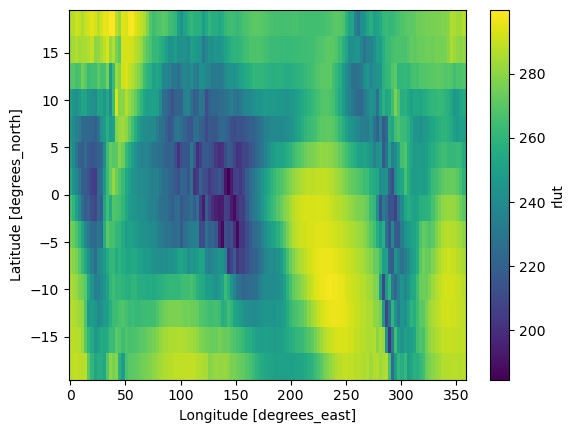

In [60]:
# Opening Files:
model = models[0]
ds = xr.open_mfdataset([os.path.join(TempDataLocation, f'{model}_amip_{var}_processed.nc') for var in ['rsut', 'rlut']], use_cftime=True, concat_dim=None)

ds.rlut.mean('time').plot()
ds